# Homework 4

## References

-   Lectures 13-16 (inclusive).

## Instructions

-   Type your name and email in the "Student details" section below.
-   Develop the code and generate the figures you need to solve the problems using this notebook.
-   For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
-   The total homework points are 100. Please note that the problems are not weighed equally.


In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline
from matplotlib.pyplot import Axes
import seaborn as sns

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

sns.set_context("paper")
sns.set_style("ticks")

In [2]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from sklearn.linear_model import ARDRegression, BayesianRidge, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as st

from dataclasses import dataclass
from typing import Callable, Type, Any

In [3]:
import sys
from functools import partial

sys.path.append("../utils/")

from download import download

DATA_FOLDER = "../data/"
download = partial(download, target_dir=DATA_FOLDER)

## Student details

-   **First Name:** Matthew
-   **Last Name:** Hansen
-   **Email:** hanse217@purdue.edu


# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations


In [4]:
url = (
    "https://github.com/PredictiveScienceLab/data-analytics-se/"
    "raw/master/lecturebook/data/stress_strain.txt"
)
file_path = download(url)
stress_strain_data = np.loadtxt(file_path)

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:

-   They took a rectangular chunk of the material and marked the position of each one of its atoms;
-   They started applying a tensile force along one dimension.
    The atoms are coupled together through electromagnetic forces, and they must all satisfy Newton's law of motion.
-   For each value of the applied tensile force, they marked the stress (force be unit area) in the middle of the material and the corresponding strain of the material (percent elongation in the pulling direction).
-   Eventually, the material entered the plastic regime and broke.
    Here is a visualization of the data:


In [5]:
STRAIN_LABEL = r"Strain, $\epsilon$"
STRESS_LABEL = r"Stress, $\sigma$ (MPa)"


def stress_strain_ax() -> Axes:
    return plt.axes(xlabel=STRAIN_LABEL, ylabel=STRESS_LABEL)

In [6]:
strain = stress_strain_data[:, 0]  # %
stress = stress_strain_data[:, 1]  # MPa

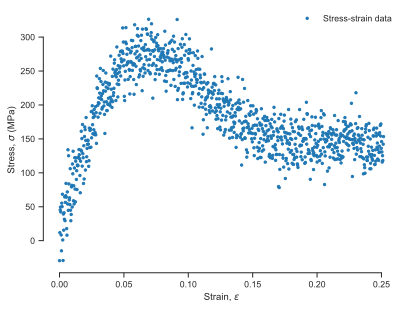

In [7]:
ax = stress_strain_ax()
ax.plot(strain, stress, ".", label="Stress-strain data")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)

Note that you don't necessarily get a unique stress for each particular value of the strain.
This is because the atoms are jiggling around due to thermal effects.
So, there is always this "jiggling" noise when measuring the stress and the strain.
We want to process this noise to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the material, affected by the fine structure, e.g., the chemical bonds, the crystalline structure, any defects, etc.
It is a required input to the mechanics of materials.


## Part A - Fitting the stress-strain curve in the elastic regime

The very first part of the stress-strain curve should be linear.
It is called the _elastic regime_.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the _Young modulus_ of the material.
Assume that you measure $\epsilon$ without noise, but your measured $\sigma$ is noisy.

### Subpart A.I

First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.


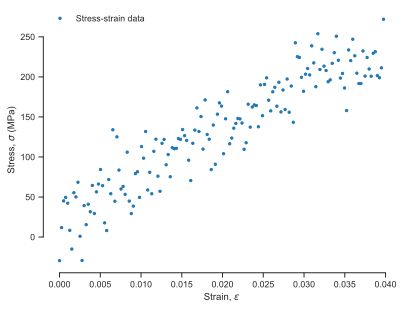

In [8]:
epsilon_linear = 0.04

strain_linear = strain[strain < epsilon_linear]
stress_linear = stress[strain < epsilon_linear]

ax = stress_strain_ax()
ax.plot(strain_linear, stress_linear, ".", label="Stress-strain data")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)

Split your data into training and validation.

**Hint:** You may use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.


In [9]:
strain_train, strain_valid, stress_train, stress_valid = train_test_split(
    strain_linear, stress_linear, test_size=0.33
)

Use the following to visualize your split:


In [10]:
def plot_split_data(
    x_train: NDArray, y_train: NDArray, x_valid: NDArray, y_valid: NDArray, ax: Axes
):
    ax.plot(x_train, y_train, ".", label="Training data")
    ax.plot(x_valid, y_valid, "x", label="Validation data")

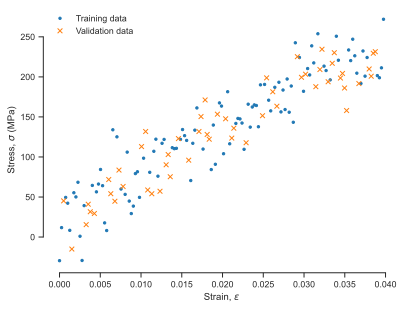

In [11]:
ax = stress_strain_ax()
plot_split_data(strain_train, stress_train, strain_valid, stress_valid, ax)
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)

### Subpart A.II

Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.


In [12]:
def get_linear_design_matrix(x: NDArray) -> NDArray:
    assert isinstance(x, np.ndarray)
    assert x.ndim == 1, "x must be a 1D array"
    x = x[:, np.newaxis]
    ones = np.ones_like(x)
    return np.hstack([ones, x])


@dataclass
class Model:
    model_type: Type[ARDRegression | BayesianRidge]
    phi_func: Callable[[Any], NDArray]
    phi_args: tuple[Any] = ()

    def fit(self, x: NDArray, y: NDArray):
        Phi = self.phi_func(x, *self.phi_args)
        self.model = self.model_type(fit_intercept=False).fit(Phi, y)
        with np.printoptions(precision=3):
            print(f"{self.model_type.__name__} Fit Results:")
            print(f"𝜎 = {self.noise_var}")
            print(f"𝛼 = {self.weight_precision}")
            print(f"m = {self.mean_weights}")
            print(f"S = {self.cov_matrix}")

    @property
    def noise_var(self) -> float:
        return np.sqrt(1.0 / self.model.alpha_)

    @property
    def weight_precision(self) -> float | NDArray:
        return self.model.lambda_

    @property
    def mean_weights(self) -> NDArray:
        return self.model.coef_

    @property
    def cov_matrix(self) -> NDArray:
        return self.model.sigma_

    def weight_posterior(self, nugget: float = 0) -> st.rv_continuous:
        m = self.mean_weights
        S = self.cov_matrix
        return st.multivariate_normal(m, S + nugget * np.eye(S.shape[0]))

    def get_phi(self, x: NDArray) -> NDArray:
        return self.phi_func(x, *self.phi_args)

    def get_predicted(self, x: NDArray) -> tuple[NDArray, NDArray]:
        Phi = self.phi_func(x, *self.phi_args)
        mean, std = self.model.predict(Phi, return_std=True)
        return mean, std

In [13]:
degree = 1
model = Model(BayesianRidge, get_linear_design_matrix)
model.fit(strain_train, stress_train)

BayesianRidge Fit Results:
𝜎 = 27.69951429890785
𝛼 = 6.530966812378326e-08
m = [  26.377 5528.843]
S = [[ 2.808e+01 -1.066e+03]
 [-1.066e+03  5.454e+04]]


### Subpart A.III

Calculate the mean square error of the validation data.


In [14]:
def mean_square_error(model: Model, x: NDArray, y: NDArray) -> float:
    predicted, _ = model.get_predicted(x)
    return np.mean((predicted - y) ** 2)

In [15]:
mse = mean_square_error(model, strain_valid, stress_valid)
print(f"Mean Square Error: {mse:1.2f}")

Mean Square Error: 607.88


### Subpart A.IV

Make the observations vs predictions plot for the validation data.


In [16]:
def even_span(x: NDArray, N: int = 100) -> NDArray:
    return np.linspace(x.min(), x.max(), N)


def plot_observation_vs_prediction(model: Model, x: NDArray, y: NDArray):
    ax = plt.axes(xlabel="Predictions", ylabel="Observations")
    y_predicted, _ = model.get_predicted(x)
    ax.plot(y_predicted, y, ".")
    ys = even_span(y)
    ax.plot(ys, ys)
    sns.despine(trim=True)

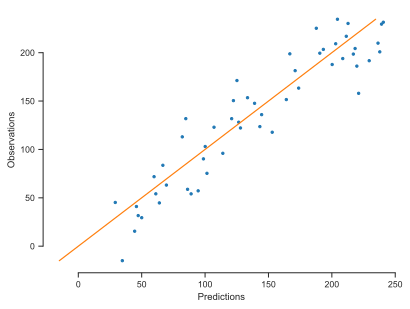

In [17]:
plot_observation_vs_prediction(model, strain_valid, stress_valid)

### Subpart A.V

Compute and plot the standardized errors for the validation data.


In [18]:
def get_standardized_error(model: Model, x: NDArray, y: NDArray) -> NDArray:
    predicted, std = model.get_predicted(x)
    return (y - predicted) / std


def plot_standardized_error(model: Model, x: NDArray, y: NDArray):
    std_err = get_standardized_error(model, x, y)
    idx = np.arange(0, len(std_err))
    ax = plt.axes(
        xlabel="Prediction Index, $i$", ylabel=r"Standardized Error, $\epsilon_i$"
    )
    ax.plot(idx, std_err, ".", label="Standardized Errors")
    ax.hlines([-1.96, 1.96], idx[0], idx[-1], colors="r", linestyles="--")
    sns.despine(trim=True)

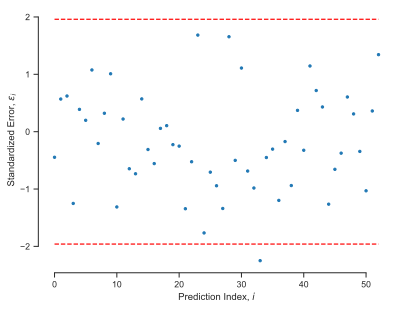

In [19]:
plot_standardized_error(model, strain_valid, stress_valid)

### Subpart A.VI

Make the quantile-quantile plot of the standardized errors.


In [20]:
def plot_quantile_quantile(model: Model, x: NDArray, y: NDArray):
    std_err = get_standardized_error(model, x, y)
    ax = plt.axes(xlabel="Theoretical Quantiles", ylabel="Ordered Values")
    st.probplot(std_err, dist=st.norm, plot=ax)
    sns.despine(trim=True)

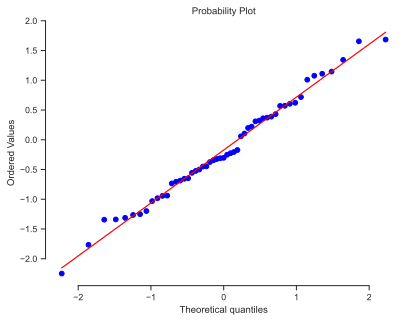

In [21]:
plot_quantile_quantile(model, strain_valid, stress_valid)

### Subpart A.VII

Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.


In [22]:
def plot_posterior_predictive(
    model: Model,
    x: NDArray,
    y: NDArray,
    ax: Axes,
):
    xx = even_span(x)
    yy_mean, yy_measured_std = model.get_predicted(xx)

    sigma = model.noise_var
    yy_std = np.sqrt(yy_measured_std**2 - sigma**2)
    yy_le = yy_mean - 2.0 * yy_std
    yy_ue = yy_mean + 2.0 * yy_std
    yy_lae = yy_mean - 2.0 * yy_measured_std
    yy_uae = yy_mean + 2.0 * yy_measured_std

    ax.plot(xx, yy_mean, "r", label="Posterior mean")
    ax.fill_between(
        xx,
        yy_le,
        yy_ue,
        color="red",
        alpha=0.25,
        label="95% epistemic credible interval",
    )
    ax.fill_between(xx, yy_lae, yy_le, color="green", alpha=0.25)
    ax.fill_between(
        xx,
        yy_ue,
        yy_uae,
        color="green",
        alpha=0.25,
        label="95% epistemic + aleatory credible interval",
    )
    ax.plot(x, y, "kx", label="Observed data")
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)

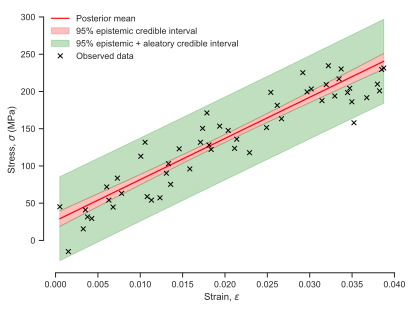

In [23]:
plot_posterior_predictive(model, strain_valid, stress_valid, ax=stress_strain_ax())

### Subpart A. VIII

Visualize the posterior of the Young modulus, $E$, conditioned on the data.


In [24]:
def plot_pdf(
    rv: st.rv_continuous,
    tail_omitted: float = 0.001,
    ppf_step: float = 0.001,
    label: str = None,
):
    pct = np.arange(tail_omitted, 1 - tail_omitted, ppf_step)
    x = rv.ppf(pct)
    y = rv.pdf(x)
    ax = plt.axes(xlabel="$x$", ylabel="$p(x)$")
    ax.plot(x, y, label=label)
    if label:
        ax.legend()

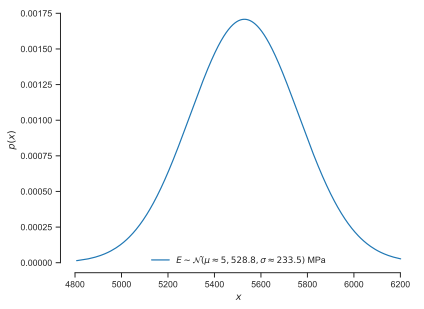

In [25]:
E_mean = model.mean_weights[1]
E_std = np.sqrt(model.cov_matrix[1, 1])
E_posterior = st.norm(E_mean, E_std)

E_normal_label = rf"$E \sim \mathcal{{N}}(\mu \approx {E_mean:,.1f}, \sigma \approx {E_std:,.1f})$ MPa"
plot_pdf(E_posterior, label=E_normal_label)
plt.legend(frameon=False)
sns.despine(trim=True)

### Subpart A.IX

Take five samples of stress-strain curve in the elastic regime and visualize them.


In [26]:
def plot_posterior_samples(
    model: Model,
    x: NDArray,
    y: NDArray,
    n_samples: int,
    ax: Axes,
    nugget: float = 0,
):
    xx = even_span(x)
    Phi_xx = model.get_phi(xx)
    w_post = model.weight_posterior(nugget)
    for _ in range(n_samples):
        w_sample = w_post.rvs()
        yy_sample = Phi_xx @ w_sample
        ax.plot(xx, yy_sample, "r", lw=0.5)

    ax.plot([], [], "r", lw=0.5, label="Posterior samples")
    ax.plot(x, y, "kx", label="Observed data")
    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)

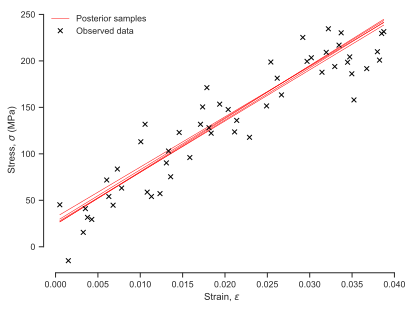

In [27]:
plot_posterior_samples(model, strain_valid, stress_valid, 5, ax=stress_strain_ax())

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.


In [28]:
E_low = E_posterior.ppf(0.025)
E_high = E_posterior.ppf(0.975)
print(f"95% Confidence Interval: {E_low:.2f} - {E_high:.2f} MPa")

95% Confidence Interval: 5071.11 - 5986.57 MPa


### Subpart A.XI

If you had to pick a single value for the Young modulus $E$, what would it be and why?


Since the posterior mean balances information from both the prior and likelihood, the mean is a decent choice.


In [29]:
E_mean = E_posterior.expect()
print(f"Posterior mean: {E_mean:.2f} MPa")

Posterior mean: 5528.84 MPa


## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We want to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.


In [30]:
strain_train, strain_valid, stress_train, stress_valid = train_test_split(
    strain, stress, test_size=0.33
)

Use the following to visualize your split:


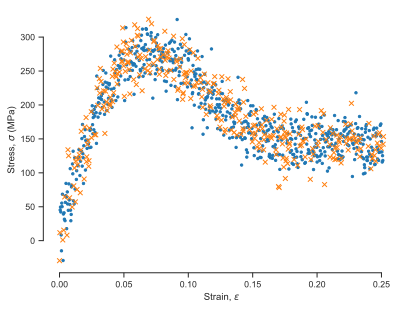

In [31]:
plot_split_data(
    strain_train, stress_train, strain_valid, stress_valid, ax=stress_strain_ax()
)
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)

### Subpart B.II - Model the entire stress-strain relationship.

To do this, we will set up a generalized linear model to capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:

-   It is linear in the parameters to be estimated,
-   It has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We will use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime, and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.


You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &=
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!


To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

We include the first derivative because we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.


Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other
parameters.
I am going to spare you the details.
The result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:


In [32]:
def compute_design_matrix(epsilon: NDArray, epsilon_l: float, d: int) -> NDArray:
    """Compute the design matrix for the stress-strain curve problem.

    Arguments:
        epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.

    Returns:
        A design matrix n x d
    """
    assert isinstance(epsilon, np.ndarray)
    assert epsilon.ndim == 1, (
        "Pass the array as epsilon.flatten(), if it is two dimensional"
    )
    n = epsilon.shape[0]
    Phi = np.ndarray((n, d))
    step = np.ones(n)
    step[epsilon < epsilon_l] = 0
    Phi[:, 0] = epsilon
    for i in range(2, d + 1):
        a = (i - 1) * epsilon_l**i
        b = i * epsilon * epsilon_l ** (i - 1)
        c = epsilon**i
        Phi[:, i - 1] = (a - b + c) * step
    return Phi

Visualize the basis functions here:


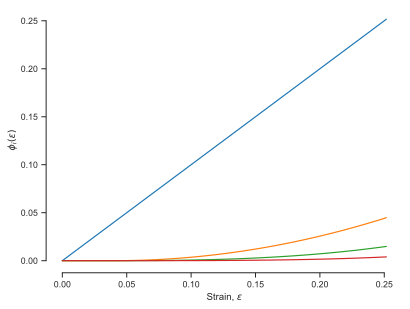

In [33]:
d = 4
eps = np.linspace(0, strain.max(), 100)
Phi = compute_design_matrix(eps, epsilon_linear, d)

ax = plt.axes(xlabel=STRAIN_LABEL, ylabel=r"$\phi_i(\epsilon)$")
ax.plot(eps, Phi)
sns.despine(trim=True)

### Subpart B.III

Fit the model using automatic relevance determination and demonstrate that it works well by doing everything we did above (MSE, observations vs. predictions plot, standardized errors, etc.).


In [34]:
model = Model(ARDRegression, compute_design_matrix, (epsilon_linear, d))
model.fit(strain_train, stress_train)

ARDRegression Fit Results:
𝜎 = 26.162185969497678
𝛼 = [3.389e-08 1.670e-11 7.703e-13 3.001e-13]
m = [    5432.174  -244643.805  1138927.983 -1824293.982]
S = [[ 2.295e+03 -2.232e+05  1.202e+06 -2.148e+06]
 [-2.232e+05  3.276e+07 -1.893e+08  3.583e+08]
 [ 1.202e+06 -1.893e+08  1.108e+09 -2.118e+09]
 [-2.148e+06  3.583e+08 -2.118e+09  4.086e+09]]


In [35]:
@dataclass
class Diagnostics:
    model: Model  # fitted model
    x: NDArray  # validation data
    y: NDArray

    def mean_square_error(self):
        print(
            f"Mean Square Error: {mean_square_error(self.model, self.x, self.y):1.2f}"
        )

    def plot_observation_vs_prediction(self):
        plot_observation_vs_prediction(self.model, self.x, self.y)

    def plot_standardized_error(self):
        plot_standardized_error(self.model, self.x, self.y)

    def plot_quantile_quantile(self):
        plot_quantile_quantile(self.model, self.x, self.y)

    def alpha_plot(self):
        alpha = self.model.weight_precision
        ax = plt.axes(xlabel="$i$", ylabel=r"$\alpha_i$")
        sns.barplot(x=list(range(1, 11)), y=alpha, ax=ax).set(yscale="log")
        sns.despine(trim=True)

In [36]:
diagnostics = Diagnostics(model, strain_valid, stress_valid)
diagnostics.mean_square_error()

Mean Square Error: 792.35


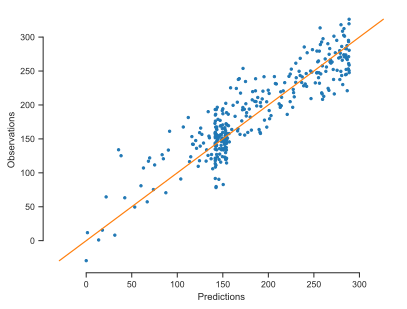

In [37]:
diagnostics.plot_observation_vs_prediction()

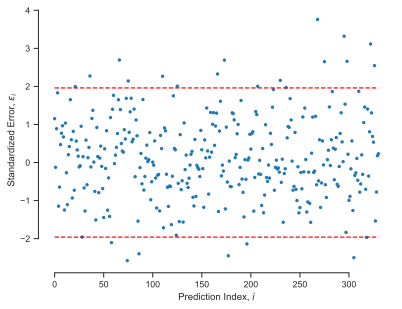

In [38]:
diagnostics.plot_standardized_error()

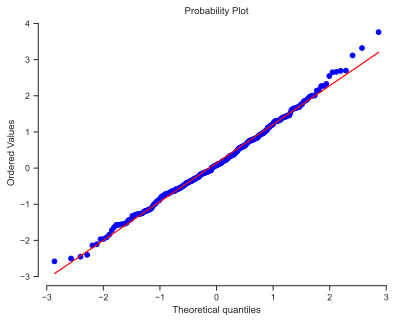

In [39]:
diagnostics.plot_quantile_quantile()

### Subpart B.IV

Visualize the epistemic and aleatory uncertainty in the stess-strain relation.


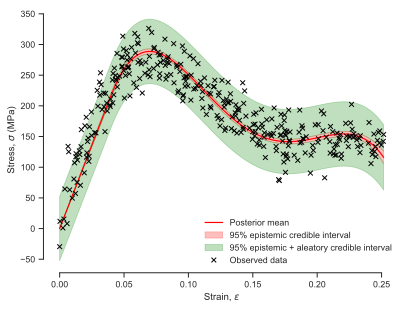

In [40]:
plot_posterior_predictive(model, strain_valid, stress_valid, stress_strain_ax())

### Subpart B.V - Extract the ultimate strength

Now, you will quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:

-   Visualize the posterior of the ultimate strength.
-   Find a 95% credible interval for the ultimate strength.
-   Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:

-   Define a dense set of strain points between 0 and 0.25.
-   Repeatedly:
    -   Sample from the posterior of the weights of your model
    -   For each sample, evaluate the stresses at the dense set of strain points defined earlier
    -   For each sampled stress vector, find the maximum. This is a sample of the ultimate strength.


Mean Ultimate Strength: 288.61 MPa
95% Confidence Interval: 284.72 - 292.40 MPa


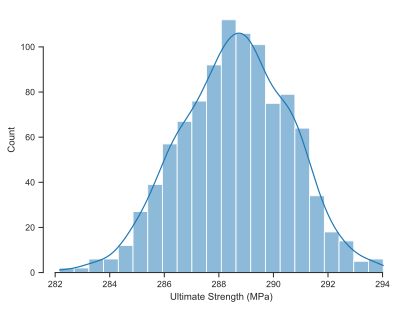

In [41]:
strain_mesh = np.linspace(0, 0.25, 100)
w_posterior = model.weight_posterior()
N_samples = 1000
ultimate_strength_samples = np.empty(N_samples)
for i in range(N_samples):
    Phi = model.get_phi(strain_mesh)
    w_sample = w_posterior.rvs()
    stress_mesh = Phi @ w_sample
    ultimate_strength_samples[i] = stress_mesh.max()

sns.histplot(ultimate_strength_samples, kde=True).set(xlabel=r"Ultimate Strength (MPa)")
sns.despine(trim=True)

mean_US = ultimate_strength_samples.mean()
mu_025 = np.percentile(ultimate_strength_samples, 2.5)
mu_975 = np.percentile(ultimate_strength_samples, 97.5)

print(f"Mean Ultimate Strength: {mean_US:.2f} MPa")
print(f"95% Confidence Interval: {mu_025:.2f} - {mu_975:.2f} MPa")

# Problem 2 - Optimizing the performance of a compressor

In this problem, we will need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google Drive or just download it with the code segment below:


In [42]:
url = (
    "https://github.com/PredictiveScienceLab/data-analytics-se/"
    "raw/master/lecturebook/data/compressor_data.xlsx"
)
data_path = download(url)
compressor_data = pd.read_excel(data_path)
compressor_data.head()

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
0,-30,11,25,8,35,60,28.8,8.000000,1557,901,4.4,1.73,0.467
1,-30,11,30,8,35,60,23.0,6.388889,1201,881,4.0,1.36,0.425
2,-30,11,35,8,35,60,17.9,4.972222,892,858,3.7,1.04,0.382
3,-25,11,25,8,35,60,46.4,12.888889,2509,1125,5.3,2.23,0.548
4,-25,11,30,8,35,60,40.2,11.166667,2098,1122,5.1,1.87,0.519


The data are part of an experimental study of a variable-speed reciprocating compressor.
The experimentalists varied two temperatures, $T_e$ and $T_c$ (both in C), and they measured various other quantities.
We aim to learn the map between $T_e$ and $T_c$ and measure Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.


In [43]:
temp = compressor_data[["T_e", "T_c"]].values
capacity = compressor_data["Capacity"].values
power = compressor_data["Power"].values

Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**

-   You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
-   You should split your data into training and validation and use various validation metrics to ensure your models make sense.
-   Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.


## Part A - Fit the capacity

### Subpart A.I

Please don't just fit. Split in training and test and use all the usual diagnostics.


In [44]:
def compute_design_matrix(x: NDArray, degree: int) -> NDArray:
    return PolynomialFeatures(degree).fit_transform(x)

In [45]:
degree = 3
temp_train, temp_valid, capacity_train, capacity_valid = train_test_split(
    temp, capacity, test_size=0.33, random_state=13
)
model = Model(ARDRegression, compute_design_matrix, (degree,))
model.fit(temp_train, capacity_train)

ARDRegression Fit Results:
𝜎 = 3.009899937082784
𝛼 = [4.219e-09 3.011e-06 3.050e-05 1.802e-02 1.059e-01 2.596e+01 1.519e+03
 5.419e+02 1.364e+03 1.419e+04]
m = [ 1.540e+04  5.763e+02 -1.811e+02  7.449e+00 -3.073e+00  1.965e-01
  2.561e-02 -4.293e-02 -2.702e-02  0.000e+00]
S = [[ 6.131e+01  2.778e+00 -2.930e+00 -6.650e-03 -1.383e-01  3.228e-02
   1.642e-06  1.273e-04  1.562e-03]
 [ 2.778e+00  1.065e+00 -1.543e-01  1.683e-02 -4.959e-02  1.907e-03
   9.030e-05 -3.998e-04  5.342e-04]
 [-2.930e+00 -1.543e-01  1.449e-01 -6.330e-04  7.644e-03 -1.631e-03
  -1.327e-05  9.131e-06 -8.585e-05]
 [-6.650e-03  1.683e-02 -6.330e-04  6.592e-04 -7.092e-04  1.359e-05
   6.905e-06 -1.246e-05  6.861e-06]
 [-1.383e-01 -4.959e-02  7.644e-03 -7.092e-04  2.376e-03 -9.429e-05
  -3.954e-06  1.747e-05 -2.616e-05]
 [ 3.228e-02  1.907e-03 -1.631e-03  1.359e-05 -9.429e-05  1.867e-05
   2.031e-07 -2.399e-07  1.057e-06]
 [ 1.642e-06  9.030e-05 -1.327e-05  6.905e-06 -3.954e-06  2.031e-07
   1.383e-07 -8.499e-08  3.951e

In [46]:
diagnostics = Diagnostics(model, temp_valid, capacity_valid)

In [47]:
diagnostics.mean_square_error()

Mean Square Error: 11.76


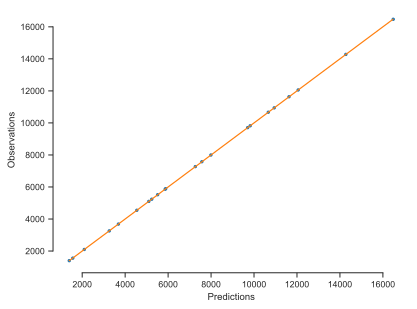

In [48]:
diagnostics.plot_observation_vs_prediction()

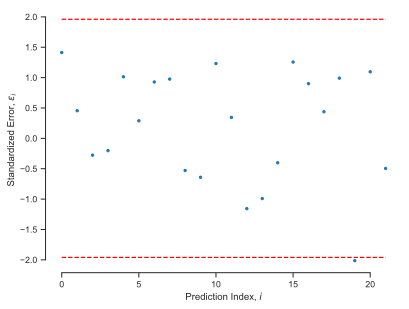

In [49]:
diagnostics.plot_standardized_error()

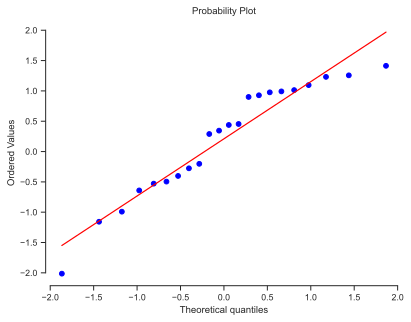

In [50]:
diagnostics.plot_quantile_quantile()

### Subpart A.II

What is the noise variance you estimated for the Capacity?


In [51]:
print(f"Capacity Noise Variance: {model.noise_var:.2f}")

Capacity Noise Variance: 3.01


### Subpart A.III

Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?


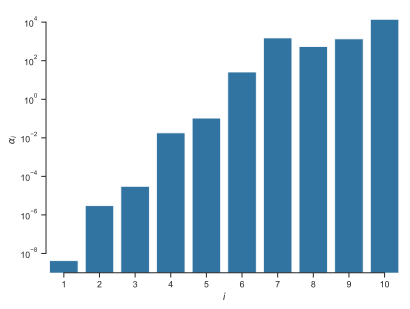

In [52]:
diagnostics.alpha_plot()

Based on the weight precisions, the most important features are the first 5 terms of the model. That is,

$$
y \approx w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2
$$


## Part B - Fit the Power

### Subpart B.I

Please don't just fit. Split in training and test and use all the usual diagnostics.


In [53]:
temp_train, temp_valid, power_train, power_valid = train_test_split(
    temp, power, test_size=0.33, random_state=13
)
model = Model(ARDRegression, compute_design_matrix, (degree,))
model.fit(temp_train, power_train)

ARDRegression Fit Results:
𝜎 = 28.230700522355672
𝛼 = [8.495e-06 5.830e-04 2.602e-04 1.627e+00 3.816e-01 5.800e+00 1.363e+04
 3.882e+05 1.124e+04 3.269e+04]
m = [337.32  -41.36   61.92   -0.783   1.618  -0.414   0.      0.      0.
   0.   ]
S = [[ 3.932e+03  3.816e+01 -1.861e+02  1.691e-01 -9.931e-01  2.035e+00]
 [ 3.816e+01  4.522e+00 -1.643e+00  5.515e-02 -8.771e-02  1.551e-02]
 [-1.861e+02 -1.643e+00  9.103e+00 -1.187e-02  4.383e-02 -1.017e-01]
 [ 1.691e-01  5.515e-02 -1.187e-02  1.522e-03 -7.205e-04  1.383e-04]
 [-9.931e-01 -8.771e-02  4.383e-02 -7.205e-04  1.954e-03 -4.247e-04]
 [ 2.035e+00  1.551e-02 -1.017e-01  1.383e-04 -4.247e-04  1.158e-03]]


In [54]:
diagnostics = Diagnostics(model, temp_valid, power_valid)
diagnostics.mean_square_error()

Mean Square Error: 994.50


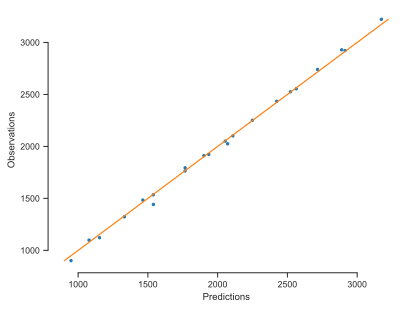

In [55]:
diagnostics.plot_observation_vs_prediction()

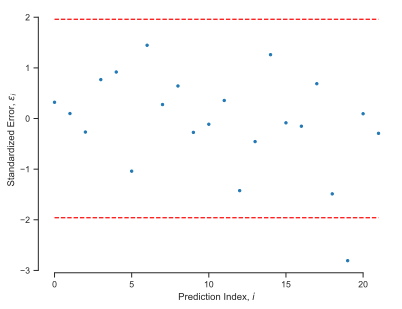

In [56]:
diagnostics.plot_standardized_error()

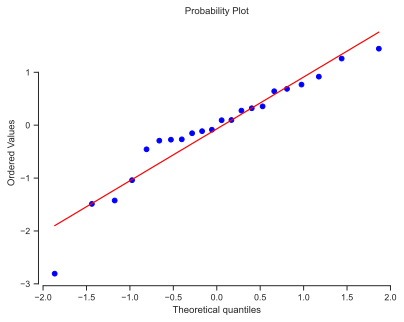

In [57]:
diagnostics.plot_quantile_quantile()

### Subpart B.II

What is the noise variance you estimated for the Power?


In [58]:
print(f"Power Noise Variance, 𝜎 = {model.noise_var:.2f}")

Power Noise Variance, 𝜎 = 28.23


### Subpart B.III

Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?


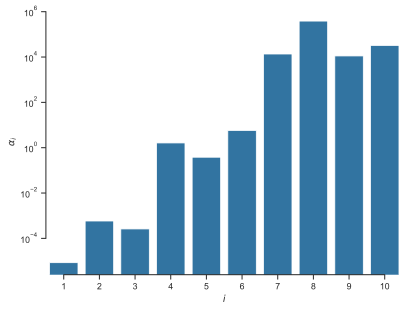

In [59]:
diagnostics.alpha_plot()

Based on the weight precisions, the most important features for Power are the first 6 terms of the model. That is,

$$
y \approx w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2
$$


# Problem 3 - Explaining the Challenger disaster

On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced to the rubber O-rings, which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propellant through the nozzles, thus producing thrust).

The performance of the O-ring material was sensitive to the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google Drive or run the code cell below).


In [60]:
url = (
    "https://github.com/PredictiveScienceLab/data-analytics-se"
    "/raw/master/lecturebook/data/challenger_data.csv"
)
file_path = download(url)
raw_data = pd.read_csv(file_path)
raw_data.head()

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0


The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled `Damage Incident` has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We will use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before proceeding to the data analysis, let's clean the data up.

First, we drop all the bad records:


In [61]:
clean_data_0 = raw_data.dropna()
clean_data_0.head()

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0


We also don't need the last record. Remember that the temperature on the day of the Challenger accident was 31 degrees F.


In [62]:
TEMPERATURE_LABEL = "Temperature (ºF)"

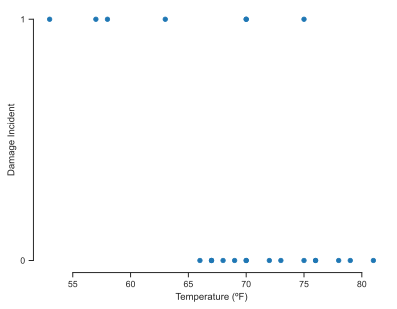

In [63]:
clean_data = clean_data_0[:-1]
clean_data.plot(kind="scatter", x="Temperature", y="Damage Incident")
plt.xlabel(TEMPERATURE_LABEL)
sns.despine(trim=True)

Let's extract the features and the labels:


In [64]:
temperature = clean_data["Temperature"].values
damage = clean_data["Damage Incident"].values.astype(float)

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Refrain from validating because there is little data.
Just use a simple model so that you don't overfit.


In [65]:
Phi = get_linear_design_matrix(temperature)
model = LogisticRegression(penalty=None, fit_intercept=False).fit(Phi, damage)

## Part B - Plot the probability of damage as a function of temperature

Plot the probability of damage as a function of temperature.


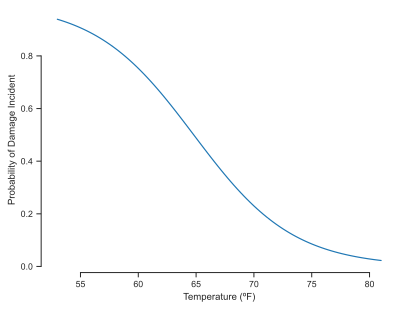

In [66]:
T_span = even_span(temperature)
Phi_T = get_linear_design_matrix(T_span)
predictions = model.predict_proba(Phi_T)
ax = plt.axes(xlabel=TEMPERATURE_LABEL, ylabel="Probability of Damage Incident")
ax.plot(T_span, predictions[:, 1])
sns.despine(trim=True)

## Part C - Decide whether or not to launch

The temperature on the day of the Challenger accident was 31ºF.
Start by calculating the probability of damage at 31ºF.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.


In [67]:
T_31 = np.array([31])
Phi_31 = get_linear_design_matrix(T_31)
prediction_31 = model.predict_proba(Phi_31)
print(f"Probability of Damage at 31ºF: {prediction_31[0, 1]:.4f}")

Probability of Damage at 31ºF: 0.9996


In [68]:
def decision(predictions) -> NDArray:
    cost_matrix = np.array([[0, 10], [2, 1]])
    exp_cost = np.einsum("ij,kj->ki", cost_matrix, predictions)
    decisions = np.argmin(exp_cost, axis=1)
    return decisions

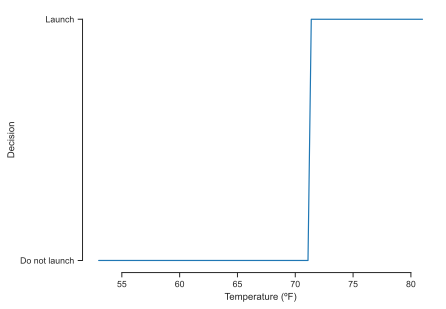

In [69]:
launch_decision = 1 - decision(predictions)
ax = plt.axes(xlabel=TEMPERATURE_LABEL, ylabel="Decision")
ax.plot(T_span, launch_decision)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Do not launch", "Launch"])
sns.despine(trim=True)

The cost matrix was developed as follows:

**Cost of correctly predicting no damage will occur - 0**<br>
No cost since the Challenger would have a successful flight (all other variables disregarded).

**Cost of incorrectly predicting no damage will occur - 10**<br>
The lives of 7 crew members are at stake. Note that I left this weight lower so there was a possibility to decide to lauch, but I hope in reality the weight would be larger.

**Cost of correctly predicting damage will occur - 1**<br>
Mission gets pushed off again, but damage would have occurred so it is worth delaying.

**Cost of incorrectly predicting damage will occur - 2**<br>
Mission gets pushed off again for no reason.

The cost matrix is then:

$$
cost = \begin{bmatrix}
0 & 10 \\
2 & 1
\end{bmatrix}
$$


In [70]:
T_min_launch = min(T_span[launch_decision == 1])
print(f"Minimum Launch Temperature: {T_min_launch:.2f}ºF")

Minimum Launch Temperature: 71.38ºF
